In [11]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import matplotlib.patches as mpatches 
from adjustText import adjust_text

# Read mdf_results from MDF and PTA analysis

In [12]:
with open('../../Analysis/MDF/out/mdf_all_results.pkl', 'rb') as f:
    mdf_results = pickle.load(f)

pta_results=pd.read_csv('../../Analysis/PTA/out/pta_reactions_data.csv').set_index('id')


# Plot MDF results

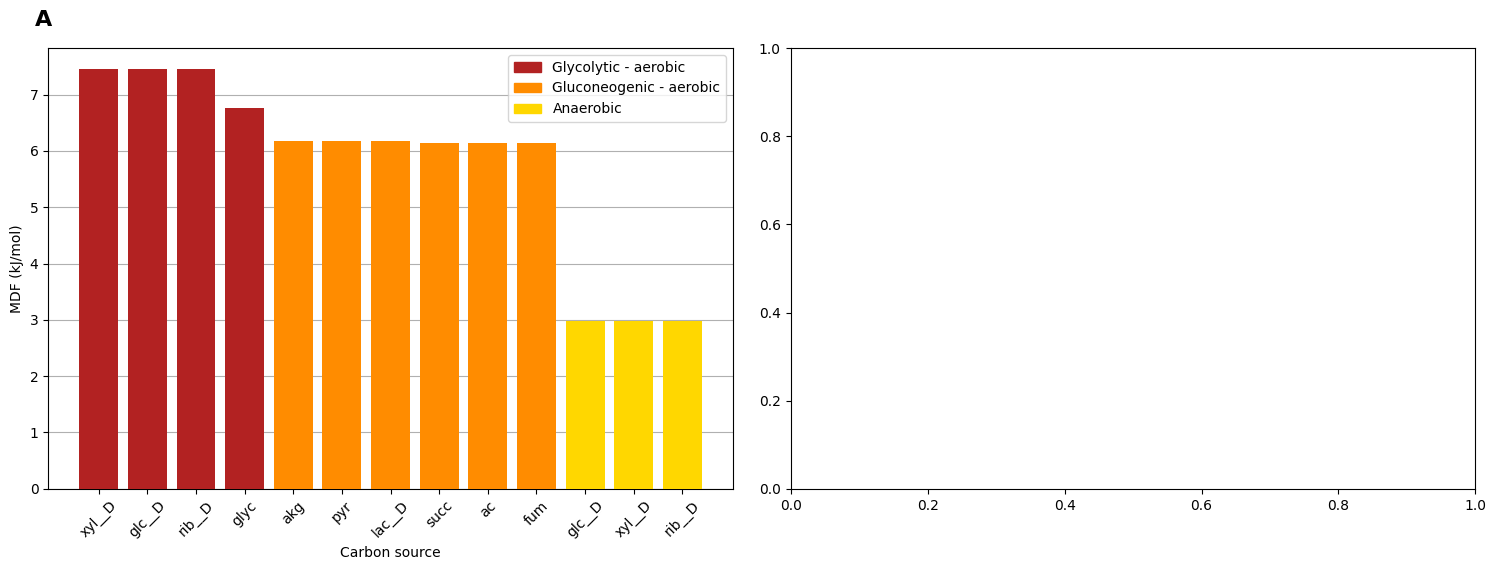

In [13]:
#Left is MDF across conditions
# Right is PTA distribution
fig,ax=plt.subplots(1,2,figsize=(15,5))
plt.subplots_adjust(right=5)
#LEFT: MDF mdf_results
carbon_sources=list(mdf_results.keys())
conditions=['aerobic','anaerobic']


mdf_values=[]
mdf_labels=[]
mdf_carbon_sources=[]
mdf_categories=[]
glycolytic_carbon_sources=['glc__D','rib__D','xyl__D','glyc']
gluconeogenic_carbon_sources=['lac__D','ac','pyr','akg','succ','fum']
for cs in carbon_sources:
    for condition in conditions:
        if mdf_results[cs][condition] is not None:
            mdf_values.append(mdf_results[cs][condition]['mdf'])
            mdf_labels.append(f'{cs}')
            mdf_carbon_sources.append(cs)

            if cs in glycolytic_carbon_sources and condition=='aerobic':
                mdf_categories.append('Glycolytic - aerobic')
            elif cs in gluconeogenic_carbon_sources and condition=='aerobic':
                mdf_categories.append('Gluconeogenic - aerobic')
            elif condition=='anaerobic':
                mdf_categories.append('Anaerobic')

color_map={'Glycolytic - aerobic':'firebrick','Gluconeogenic - aerobic':'darkorange','Anaerobic':'gold'}

plt.tight_layout()

#order
sorted_ixs=np.flip(np.argsort(mdf_values))
sorted_mdf_values=np.array(mdf_values)[sorted_ixs]
sorted_mdf_labels=np.array(mdf_labels)[sorted_ixs]
sorted_mdf_categories=np.array(mdf_categories)[sorted_ixs]
sorted_mdf_carbon_sources=np.array(mdf_carbon_sources)[sorted_ixs]
#


ax[0].bar(range(len(sorted_mdf_labels)),sorted_mdf_values,color=[color_map[cat] for cat in sorted_mdf_categories],zorder=3)
ax[0].set_xticks(range(len(sorted_mdf_labels)),sorted_mdf_labels)
ax[0].set_ylabel('MDF (kJ/mol)')
ax[0].set_xlabel('Carbon source')
ax[0].tick_params(axis='x',labelrotation=45)

#Manually add legend
# Creating legend with color box 
patches=[mpatches.Patch(color=color_map[cat], label=cat) for cat in color_map.keys()]
ax[0].legend(handles=patches) 

ax[0].text(-0.02, 1.05, 'A', transform=ax[0].transAxes, 
            size=16, weight='bold')
ax[0].grid(axis='y',zorder=0)


# Plot PTA Results

In [14]:
def flux_force_efficacy(drg_prime,T=310.15):
    R=8.31446261815324e-3 #gas constant in kJ/(K*mol)
    RT=R*T
    return (np.exp(-(drg_prime/RT))-1)/(np.exp(-(drg_prime/RT))+1)
    

In [15]:
pta_results['normalised_fluxes']=pta_results['v']/(-pta_results.loc['GLCptspp','v']).max()
pta_results['normalised_abs_fluxes']=np.abs(pta_results['normalised_fluxes'])
pta_results['driving_force']=-(pta_results['drg']*np.sign(pta_results['v']))
pta_results['flux_force_efficacy']=flux_force_efficacy(-pta_results['driving_force'])
pta_results.head()

,Unnamed: 0,v,drg0,drg,z_drg,z_drg0,sp_drg,normalised_fluxes,normalised_abs_fluxes,driving_force,flux_force_efficacy
id,,,,,,,,,,,
NDPK5,0,0.017587,0.706165,-3.784155,-0.090767,-2.902406e-01,4.112437e-10,-0.001761,0.001761,3.784155,0.625339
SHK3Dr,1,0.247364,-3.945073,-9.909952,-0.000562,-3.564609e-07,1.534814e-10,-0.024763,0.024763,9.909952,0.958039
NDPK6,2,0.017033,-1.580961,-6.071294,-0.062589,-3.635086e-01,2.531404e-10,-0.001705,0.001705,6.071294,0.826562
NDPK8,3,0.017033,2.004111,-2.486209,-0.062540,-3.172957e-01,6.357664e-10,-0.001705,0.001705,2.486209,0.447892
DHORTS,4,-0.215331,-9.637185,0.100000,1.368239,3.088587e-01,3.649279e-01,0.021556,0.021556,0.100000,0.019387


In [16]:
reactions_of_interest_abs_flux_thresh=0.05
reactions_of_interest_force_thresh=0.2


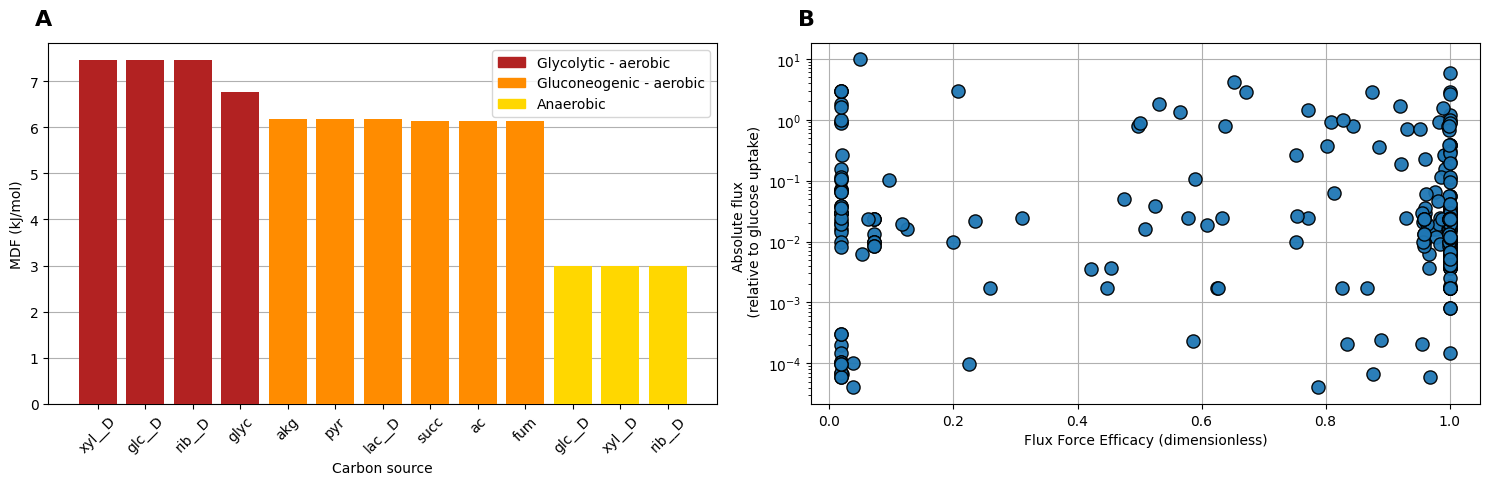

In [17]:
pta_results_filtered=pta_results.query("normalised_abs_fluxes>1e-6")
#Scatter plot of driving force vs normalised fluxes. Make dots with lighter fill than edge. make y on a log scale
ax[1].scatter(pta_results_filtered['flux_force_efficacy'],
              pta_results_filtered['normalised_abs_fluxes'],
              s=90,
              edgecolor='black',
              alpha=0.95,
              zorder=2,)


ax[1].set_yscale('log')
ax[1].set_xlabel('Flux Force Efficacy (dimensionless)')
ax[1].set_ylabel('Absolute flux \n (relative to glucose uptake)')
ax[1].text(-0.02, 1.05, 'B', transform=ax[1].transAxes, 
            size=16, weight='bold')
ax[1].grid(zorder=0)
fig.tight_layout()
fig

In [18]:
reactions_of_interest=pta_results.query(f"normalised_abs_fluxes>{reactions_of_interest_abs_flux_thresh} and flux_force_efficacy<{reactions_of_interest_force_thresh}")
reactions_of_interest=reactions_of_interest[~reactions_of_interest.index.str.contains('pp|tex')]
reactions_of_interest.head()

,Unnamed: 0,v,drg0,drg,z_drg,z_drg0,sp_drg,normalised_fluxes,normalised_abs_fluxes,driving_force,flux_force_efficacy
id,,,,,,,,,,,
ICDHyr,8,1.042095,5.295902,-0.100000,-0.181815,-0.023389,7.914619e-02,-0.104322,0.104322,0.100000,0.019387
PGI,45,-18.289000,2.675511,0.100000,0.816498,0.678039,4.084580e+00,1.830876,1.830876,0.100000,0.019387
TKT1,54,9.297775,-4.076631,-0.100000,-0.573613,-1.096252,1.182145e+00,-0.930782,0.930782,0.100000,0.019387
FUM,63,1.022346,-3.425501,-0.496941,0.060760,-0.003465,3.829559e-09,-0.102345,0.102345,0.496941,0.096057
GHMT2r,75,0.725228,-9.138161,-0.100000,0.927261,0.326923,6.467551e-02,-0.072601,0.072601,0.100000,0.019387


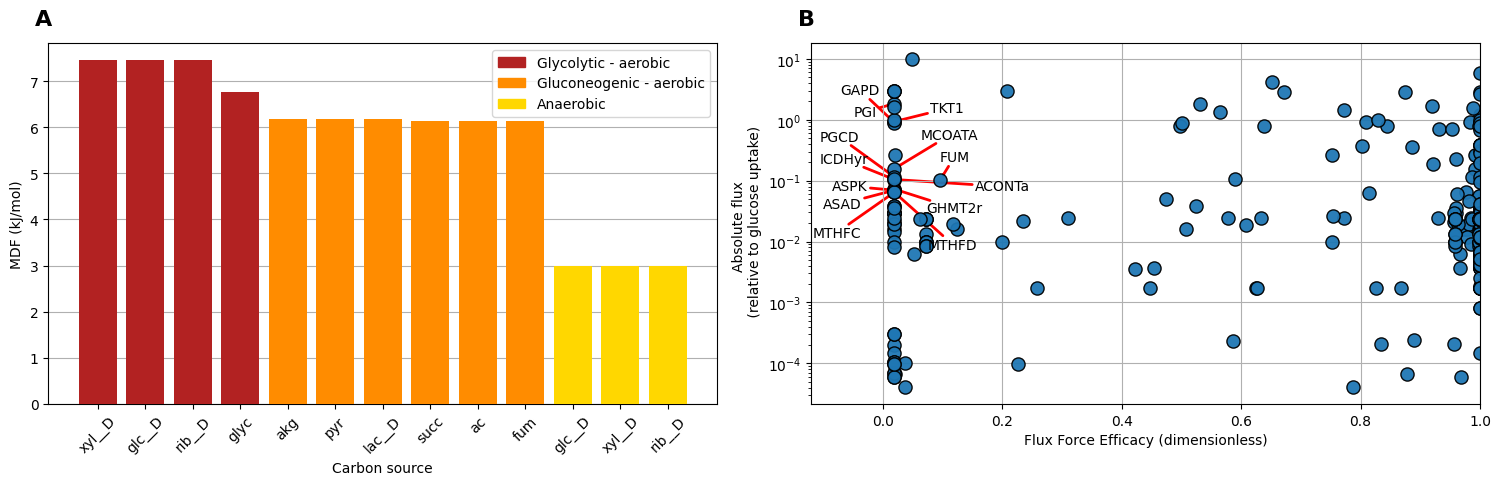

In [19]:

target_x=[]
target_y=[]
texts=[]
circles=[]
for id,row in reactions_of_interest.iterrows():
    x=row['flux_force_efficacy']
    y=row['normalised_abs_fluxes']
    target_x.append(x)
    target_y.append(y)
    texts.append(ax[1].text(x,y,id))

ax[1].set_xlim(-0.12,1)   


adjust_text(texts,
            target_x,
            target_y,
                 arrowprops=dict(arrowstyle="->", color='r', lw=2),
                 ax=ax[1],
                 expand=(2.2,1.5),
                 ensure_inside_axes=True,
                 expand_axes=(2,1.2))

fig

In [20]:
#Save
fig.savefig('../figures/MDF_PTA_combined.svg',bbox_inches='tight')
fig.savefig('../figures/MDF_PTA_combined.pdf',bbox_inches='tight')
fig.savefig('../figures/MDF_PTA_combined.png',bbox_inches='tight')